<a href="https://colab.research.google.com/github/56sarager/Graphene-Classification/blob/main/Graphene_Classification_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Zip file of images downloaded from Google Drive and uploaded to Colab (folder.zip)
import zipfile
import os

def unzip_file(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f"Extracted all files to {extract_to}")

zip_file_path = '/content/folder.zip'
extraction_directory = 'Graphene Clean Dataset'
unzip_file(zip_file_path, extraction_directory)

Extracted all files to Graphene Clean Dataset


In [2]:
!pip install ultralytics
from ultralytics import YOLO
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

# Set up paths
data_dir = '/content/Graphene Clean Dataset/Graphene Clean Dataset'
output_dir = 'dataset'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/labels'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val/images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val/labels'), exist_ok=True)

# List image files
image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
graphene_files = [f for f in image_files if f.endswith('f.jpg')]
not_graphene_files = [f for f in image_files if not f.endswith('f.jpg')]

if not image_files:
    raise ValueError("No image files found in the specified directory. Please check the path and ensure there are .png images.")

try:
    train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)
except ValueError as e:
    print("Error during train-test split:", e)
    if len(image_files) <= 1:
        train_files, val_files = image_files, []
    else:
        train_files, val_files = train_test_split(image_files, test_size=0.1, random_state=42)

# Create label files
def create_label_file(filename, label, output_dir):
    base_filename = os.path.splitext(filename)[0]
    label_path = os.path.join(output_dir, 'labels', base_filename + '.txt')
    with open(label_path, 'w') as f:
        f.write(f"{label} 0.5 0.5 1.0 1.0")  # Label, x_center, y_center, width, height (everything besides label arbitrary)

# Copy images and create labels for training set
for filename in train_files:
    label = 0 if filename in graphene_files else 1
    create_label_file(filename, label, os.path.join(output_dir, 'train'))
    shutil.copy2(os.path.join(data_dir, filename), os.path.join(output_dir, 'train/images'))

# Copy images and create labels for validation set
for filename in val_files:
    label = 0 if filename in graphene_files else 1
    create_label_file(filename, label, os.path.join(output_dir, 'val'))
    shutil.copy2(os.path.join(data_dir, filename), os.path.join(output_dir, 'val/images'))

print("Dataset creation complete. Check 'dataset/train' and 'dataset/val' for images and labels.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.3/896.3 kB 23.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Dataset creation complete. Check 'dataset/train' and 'dataset/val' for images and labels.


In [3]:
# Define the content of the YAML file
yaml_content = """
# graphene.yaml
train: /content/dataset/train/images
val: /content/dataset/val/images

nc: 2
names: ['graphene', 'not_graphene']
"""

# Write the content to a .yaml file
with open("graphene.yaml", "w") as yaml_file:
    yaml_file.write(yaml_content)

print("YAML file 'graphene.yaml' created successfully.")

YAML file 'graphene.yaml' created successfully.


In [4]:
model = YOLO("yolov8n.pt")

# Train the model
model.train(data='graphene.yaml', epochs=10, imgsz=640)

100%|██████████| 6.25M/6.25M [00:00<00:00, 94.0MB/s]


Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=graphene.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

100%|██████████| 755k/755k [00:00<00:00, 18.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 102MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/train/labels... 3945 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3945/3945 [00:02<00:00, 1618.96it/s]

train: New cache created: /content/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/val/labels... 987 images, 0 backgrounds, 0 corrupt: 100%|██████████| 987/987 [00:01<00:00, 834.13it/s]

val: New cache created: /content/dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.2G     0.2079      1.121      0.987          9        640: 100%|██████████| 247/247 [01:21<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.75it/s]

                   all        987        987      0.754      0.841      0.757      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.17G     0.1133     0.4014     0.9191          9        640: 100%|██████████| 247/247 [01:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.01it/s]

                   all        987        987      0.687      0.875      0.698      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.16G     0.1095     0.2475     0.9141          9        640: 100%|██████████| 247/247 [01:16<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.44it/s]


                   all        987        987      0.724      0.901      0.739      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.17G    0.09279     0.1869     0.9034          9        640: 100%|██████████| 247/247 [01:16<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.92it/s]

                   all        987        987      0.713      0.863      0.727      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.15G    0.07623     0.1514     0.8907          9        640: 100%|██████████| 247/247 [01:15<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.40it/s]

                   all        987        987      0.716      0.938      0.731      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.15G    0.06172      0.128     0.8896          9        640: 100%|██████████| 247/247 [01:15<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.86it/s]

                   all        987        987      0.717      0.874      0.719      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.14G    0.05299     0.1152     0.8843          9        640: 100%|██████████| 247/247 [01:16<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.45it/s]

                   all        987        987      0.741      0.903      0.811      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.17G    0.04644    0.09653     0.8753          9        640: 100%|██████████| 247/247 [01:15<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.05it/s]

                   all        987        987      0.795      0.811      0.813      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.15G    0.03635    0.08428     0.8815          9        640: 100%|██████████| 247/247 [01:15<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.56it/s]

                   all        987        987      0.817      0.995      0.853      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.15G    0.02951    0.06888     0.8795          9        640: 100%|██████████| 247/247 [01:15<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.16it/s]


                   all        987        987      0.881      0.996      0.923      0.923

10 epochs completed in 0.241 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.48it/s]


                   all        987        987      0.881      0.996      0.921      0.921
              graphene         16         16      0.762          1      0.848      0.848
          not_graphene        971        971      0.999      0.993      0.995      0.995
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7db92d4dbd30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

#Test Model on Specified Image

Path to Image: /content/3374f.jpg

image 1/1 /content/3374f.jpg: 544x640 1 graphene, 12.2ms
Speed: 2.7ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


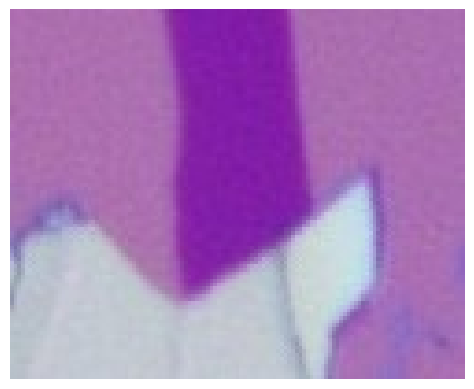

In [8]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the trained YOLO model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Path to image
image_path = input("Path to Image: ")

results = model(image_path)

# Process the results
for result in results:
    img = result.orig_img
    predictions = result.boxes

    image_with_pred = img.copy()

    if predictions is not None:
        # Loop through the predictions
        for box in predictions.xyxy:  # Access the bounding boxes (x1, y1, x2, y2, conf, class) (Once again, arbitrary)
            x1, y1, x2, y2 = box[:4].tolist()  # Extract box coordinates as list

            # Calculate center and radius for the circle
            c_x = int((x1 + x2) / 2)
            c_y = int((y1 + y2) / 2)
            radius = int((x2 - x1) / 2)

            # Draw the circle on the image
            #cv2.circle(image_with_pred, (c_x, c_y), radius, (0, 255, 0), 2)  # Green circle

    # Show the image with predictions
    plt.imshow(cv2.cvtColor(image_with_pred, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()